<a href="http://www.cosmostat.org/" target="_blank"><img align="left" width="300" src="http://www.cosmostat.org/wp-content/uploads/2017/07/CosmoStat-Logo_WhiteBK-e1499155861666.png" alt="CosmoStat Logo"></a>
<br>
<br>
<br>
<br>

# Astronomical Image Denoising
---

> Author: <a href="http://www.cosmostat.org/people/sfarrens" target="_blank" style="text-decoration:none; color: #F08080">Samuel Farrens</a>  
> Email: <a href="mailto:samuel.farrens@cea.fr" style="text-decoration:none; color: #F08080">samuel.farrens@cea.fr</a>  
> Year: 2019  
> Version: 1.0

---
<br>

The objective of this notebook is to introduce some of the tools and concepts used to remove noise from astronomical images. The content of the tutorial is in now way exhaustive and should be supplimented with further reading for a more comprehensive understanding of the topic.

If you are new to Jupyter notebooks note that cells are executed by pressing <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (&#x21E7;+ &#x23ce;). See the <a href="https://jupyter-notebook.readthedocs.io/en/stable/" target_="blanck">Jupyter documentation</a> for more details.

## Contents
---

1. [Set-Up](#1-Set-Up)
1. [Introduction](#2-Introduction)
1. [Sparse Decomposition](#3-Sparse-Decomposition)
    1. [NGC2997](#NGC2997)
    1. [Decomposition](#Decomposition)
    1. [Recombination](#Recombination)
1. [Adding Noise](#4-Adding-Noise)
    1. [Noisy Decomposition](#Noisy-Decomposition)
1. [Noise Estimation](#5-Noise-Estimation)
    1. [Smooth Median](#Smooth-Median)
    1. [Sigma Clipping](#Sigma-Clipping)
    1. [Helper Function](#Helper-Function)
    1. [Sigma Rescaling](#Sigma-Rescaling)
    1. [Weights](#Weights)
1. [Denoising](#6-Denoising)
    1. [Thresholding](#Thresholding)
    1. [Final Recombination](#Final-Recombination)
1. [Exercise](#7-Exercise)

## 1 Set-Up
---

The following cell contains some set-up commands. Be sure to execute this cell before continuing.

In [1]:
# Import the numpy package with the alias np.
import numpy as np

# Import getdata function from astropy
from astropy.io.fits import getdata

# Import noise handling functions from modopt
from modopt.signal.noise import add_noise, thresh

# Import stamp handler from sf_tools
from sf_tools.image.stamp import FetchStamps

# Import interaction module
from ipywidgets.widgets import *

# Import tutorial utilities
from tutorial_utils import decompose, recombine, noise_est, sigma_scales, plot_image, plot_decomp, plot_hist


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.0     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.0     installed
scikit-learn   : >=0.19.1  - requi

## 2 Introduction
---

Unlike many other fields of science, astrophysics relies almost entirely of observations of extremely distant objects. Large telescopes and long exposure times are required in order to capture enough photos to study these objects. This leads to various sources of distortion and noise in the obeserved images coming from: the Earth's atmosphere, the optical system used, the electronics of the detector and the random arrival of photons.

We can model the difference between the true object and what is observed as follows:

$$\mathbf{y} = \mathcal{H}\mathbf{x} + \mathbf{n}$$

where $\mathbf{y}$ is the observed image, $\mathbf{x}$ is the "true" image, $\mathcal{H}$ are the abberrations introduced by atomosphere and the optics, and $\mathbf{n}$ is the noise.

For the purposes of this tutorial we will neglect the impact of $\mathcal{H}$ and simply look the noise. Therefore, we can simplify our model as follows:

$$\mathbf{y} = \mathbf{x} + \mathbf{n}$$

To solve this problem we aim to recover $\mathbf{x}$ given $\mathbf{y}$ and assuming that $\mathbf{n}$ is Gaussian. In other words, we would like to denoise the observed image.

There are, of course, many ways to approach this problem. For the purposes of this tutorial, we will look at using a sparse wavelet decomposition of the image in order threshold out the noise.

## 3 Sparse Decomposition
---

Following the introduction to sparsity, you should be familiar with how the Fourier transform can be used to obtain the sparse representation of a signal. For this tutorial we will expand upon that same concept using wavelets.

If you are completely unfamiliar with wavelets I suggest that you have a look at this [CosmoStat notebook on wavelets](https://github.com/CosmoStat/Tutorials/blob/master/ada/wavelets_1.ipynb) for a hands-on introduction. In the meantime simply keep in mind that the objective of wavelets is to simultaneously retain some spatial and frequency information from the image.

For this tutorial we will use the *starlet* (or [Isotropic Undecimated Wavelet Transform](http://jstarck.free.fr/Chapter_Starlet2011.pdf)). The starlet transform decomposes an image, $\mathbf{x}$, into a coarse scale, $\mathbf{x}^J$, and wavelet scales, $(\boldsymbol{w}^j)_{1\leq j \leq J}$,

$$\mathbf{x} = \mathbf{x}^{J} + \sum_{j=1}^J \boldsymbol{w}^{j}$$

where the first level ($j = 1$) corresponds to the highest frequencies (*i.e.* the finest scale).

Let's have a look at how this works using an image of a galaxy. 


### NGC2997


First, let's load the image of the galaxy NGC2997, which is in Flexible Image Transport System ([FITS](https://en.wikipedia.org/wiki/FITS)) format. We can do this using the [`getdata`](https://docs.astropy.org/en/stable/io/fits/api/files.html#astropy.io.fits.getdata) function from [Astropy](https://www.astropy.org/).

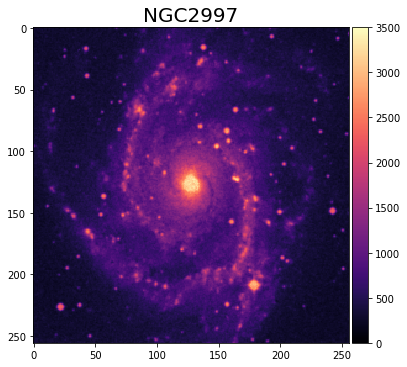

In [2]:
# Load image of NGC2997
ngc2997 = getdata('./data/ngc2997.fits')

# Plot image
plot_image(ngc2997, title='NGC2997')

We can see the typical (low spatial frequency) shape of the galaxy along with some high spatial frequency features.

### Decomposition

We can use the `decompose` function to obtain our wavlet decomposition.

In [3]:
# Uncomment the following line to show the help for the decompose function
# help(decompose)

This function uses the starlet transform from [PySAP](https://github.com/CEA-COSMIC/pysap) in order to obatin the decomposition of the image.

In [4]:
# Show starlet decomposition
def show_decomp(n_scales=None):

    # Decompose image
    ngc2997_decomp = decompose(ngc2997, n_scales=n_scales)

    # Plot decomposition
    plot_decomp(ngc2997_decomp, n_cols=3)
    
# Make interactive cell
scale_slider = IntSlider(value=2, min=2, max=6, step=1)
interact(show_decomp, n_scales=scale_slider)

interactive(children=(IntSlider(value=2, description='n_scales', max=6, min=2), Output()), _dom_classes=('widg…

<function __main__.show_decomp(n_scales=None)>

We can see that as the image is decomposed into more scales, more of the higher spatial frequency features are stripped from the corase scale. In particular, we can note that the wavelet scales are very sparse!

### Recombination

An important property of the starlet transform is that the original image can be recovered simply by summing the decomposition. This can be done using the `recombine function`.

In [5]:
# Uncomment the following line to show the help for the recombine function
# help(recombine)

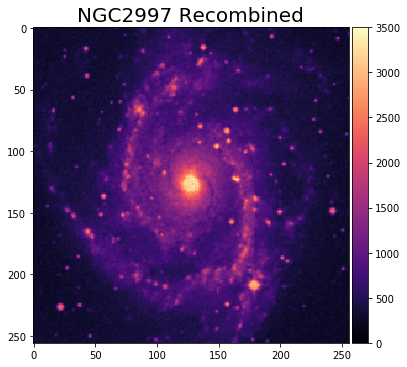

In [6]:
# Decompose image
ngc2997_decomp = decompose(ngc2997, n_scales=4)

# Recombine image
ngc2997_recomb = recombine(ngc2997_decomp)

# Plot recombined image
plot_image(ngc2997_recomb, title='NGC2997 Recombined')

## 4 Adding Noise
---

Now let's add some Gaussian noise to our image to simulate an observation ($\mathbf{y}$). To do so we can use the [`add_noise`](https://cea-cosmic.github.io/ModOpt/modopt.signal.noise.html?highlight=add_noise#modopt.signal.noise.add_noise) function from [ModOpt](https://cea-cosmic.github.io/ModOpt/). 

We will set $\sigma = 500$ to have a strong visual impact.

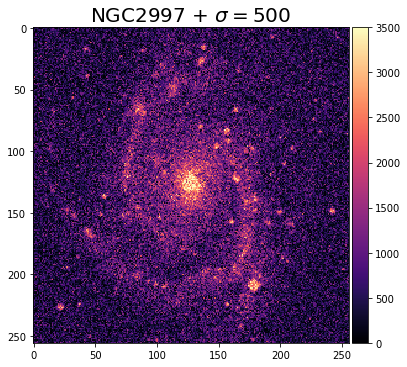

In [7]:
# Add noise with sigma=500 to image
sigma = 500
np.random.seed(0)
ngc2997_noisy = add_noise(ngc2997, sigma=sigma)

# Plot noisy image
plot_image(ngc2997_noisy, title=r'NGC2997 + $\sigma=500$')

### Noisy Decomposition

Now we can decompose our noisy observation to see what happens.

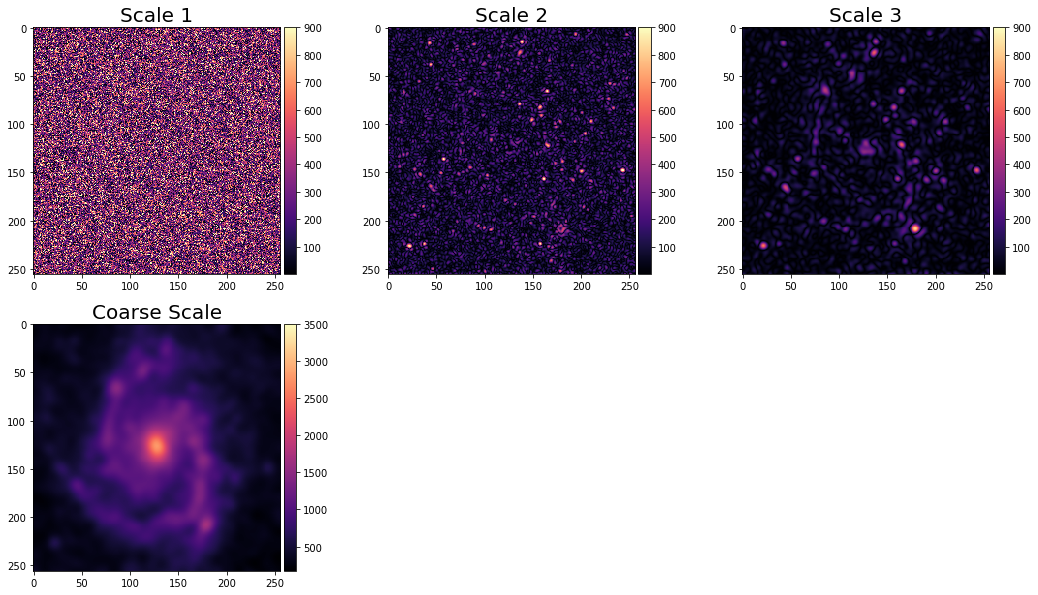

In [8]:
# Decompose noisy image
ngc2997_noisy_decomp = decompose(ngc2997_noisy, n_scales=4)

# Plot decomposition
plot_decomp(ngc2997_noisy_decomp, n_cols=3)

Right away we can see that the first scale is almost entirely noise, while the corase scale looks almost identical to that of the clean image. This gives us a very strong motivation for using sparsity to denoise our image.

## 5 Noise Estimation
---

In this toy example we know exactly how much noise we added to our image. We can demonstrate that, if we take the residual from the clean and noisy images, it is trivial to estimate the amount of noise added.

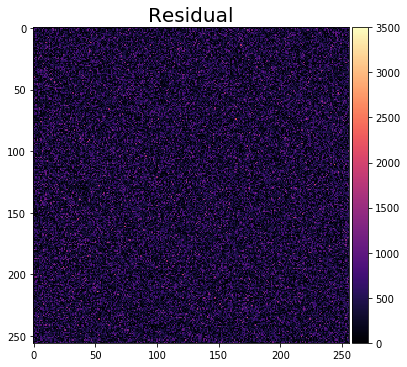

The standard deviation of resiual is 497.66.


In [9]:
# Calculate the residual
residual_noisy = ngc2997 - ngc2997_noisy

# Plot the residual
plot_image(residual_noisy, title='Residual')

# Estimate the noise standard deviation from the residual
print('The standard deviation of resiual is {:.2f}.'.format(np.std(residual_noisy)))

In real applications, however, we will simply observe a noisy image and at best hope to know what type of noise the image may contain. Thefore, the first step in our denoising process will be to estimate the amount of noise in the observed image.

### Smooth Median

First we will smooth our image by taking the median value in $3\times 3$ kernels. We can extract the stamps and calculate their median using the `FetchStamps` class from [sf_tools](https://github.com/sfarrens/sf_tools).

In [10]:
help(FetchStamps)

Help on class FetchStamps in module sf_tools.image.stamp:

class FetchStamps(builtins.object)
 |  FetchStamps(data, pixel_rad, all=False, pad_mode='constant')
 |  
 |  Fetch postage stamps
 |  
 |  This class returns a stack of postage stamps from a given 2D image array.
 |  
 |  Parameters
 |  ----------
 |  data : np.ndarray
 |      Input 2D data array
 |  pixel_rad : tuple
 |      Pixel radius in each dimension
 |  all : boolean, optional
 |      Option to select all pixels. Default (all=False)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, pixel_rad, all=False, pad_mode='constant')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_pixels(self, pixels)
 |      Get pixels
 |      
 |      This method gets the desired pixel positions.
 |      
 |      Parameters
 |      ----------
 |      pixels : list or np.ndarray
 |          List of pixel positions
 |      
 |      Raises
 |      ------
 |      ValueError
 |          For invalid numbe

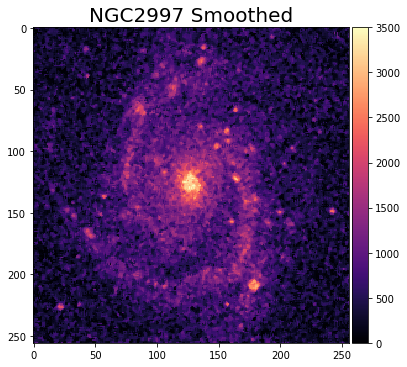

In [11]:
# Extract 3x3 kernels from noisy image can calculate their median
ngc2997_smooth = FetchStamps(ngc2997_noisy, pixel_rad=1, all=True, pad_mode='edge').scan(np.median)

# Reshape median values to image shape to produce smoothed image
ngc2997_smooth = ngc2997_smooth.reshape(ngc2997_noisy.shape)

# Plot smoothed image
plot_image(ngc2997_smooth, 'NGC2997 Smoothed')

Then we can get a rough noise map by subtracting the smoothed image from the noisy image.

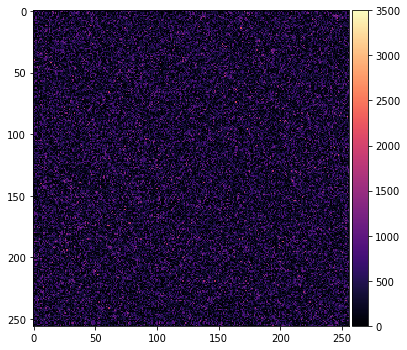

In [12]:
# Subtract smooth image from the noisy image
residual_smooth = ngc2997_noisy - ngc2997_smooth

# Plot the residual
plot_image(residual_smooth)

We can see that this looks similar the residual we had when we subtracted the noisy image from the clean image.

### Sigma Clipping

To ensure that we are not including any high spatial frequency features in our noise estimate we can perform an iterative sigma clipping procedure.

We start by calculating the mean and standard deviation of our rough noise map.

In [13]:
# Calculate the mean
mean_clip = np.mean(residual_smooth)

# Calculate the standard deviation
sigma_clip = np.std(residual_smooth)

print('Mean = {:.2f}, Sigma = {:.2f}'.format(mean_clip, sigma_clip))

Mean = 0.35, Sigma = 484.61


Then we will iteratively recalulate these values for elements, $x_i$, that satisfy $x_i - \mu < 3\sigma$ (*i.e.* excluding values in the grey area of the plot below).

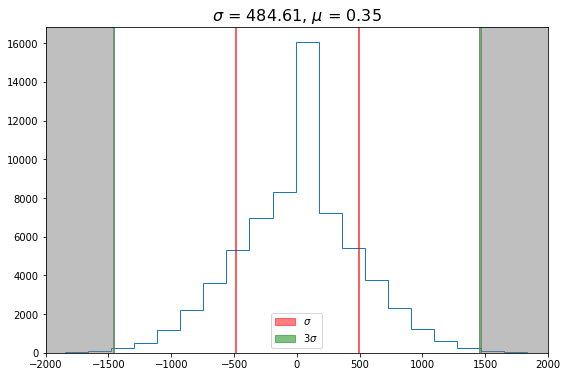

In [14]:
# Plot histogram of sigma clipping procedure
plot_hist(residual_smooth - mean_clip, sigma_clip, mean_clip)

In [15]:
# Perform iterative sigma clipping
for _iter in range(2):
    
    # Clip out elements > 3*sigma
    residual_clipped = residual_smooth[np.abs(residual_smooth - mean_clip) < (3 * sigma_clip)]

    # Recalculate mean and standard deviation
    mean_clip = np.mean(residual_clipped)
    sigma_clip = np.std(residual_clipped)

    print('Mean = {:.2f}, Sigma = {:.2f}'.format(mean_clip, sigma_clip))

Mean = 0.15, Sigma = 471.25
Mean = 0.39, Sigma = 468.76


Next, we divide the final sigma value by a correction factor to get the final noise estimate.

In [16]:
# Divide sigma by correction factor
sigma_clip /= 0.972463

print('Sigma = {:.2f}'.format(sigma_clip))

Sigma = 482.04


Which gives us a pretty reasonable estimate of our original noise standard deviation.

### Helper Function

To save some time, I provide the simple noise estimation function `noise_est` that performs all these steps for you.

In [17]:
# Uncomment the following line to show the help for the noise_est function
# help(noise_est)

In [18]:
# Estimate the noise standard deviation from the noisy image
sigma_est = noise_est(ngc2997_noisy)

print('The noise estimate is sigma={:.2f}.'.format(sigma_est))

The noise estimate is sigma=482.04.


### Sigma Rescaling

In order to threshold the decomposed image we need to rescale the noise estimate for each of the wavelet scales. To do this we multiply the estimate of the noise standard deviation by the l2-norm of the decomposition of a dirac (*i.e.* a 2D-array of zeros with a 1 at the centre).

To save time I also provide the simple helper fuction `sigma_scales` to do this.

In [19]:
# Uncomment the following line to show the help for the sigma_scales function
# help(sigma_scales)

In [20]:
# Rescale sigma for the wavelet scales
sigma_est_scales = sigma_scales(sigma_est)
print('Scaled sigma values:', sigma_est_scales)
print()

Scaled sigma values: [429.39669825  96.72738211  41.21777312]



### Weights

Finally, we multiply the rescaled sigma values by a fixed scale-dependent factor $k^j$ to provide a set of weights we can use to threshold the decomposed observation. In principal this is a factor we can play around with in order to get the best possible denoising, but previous experiments have shown a value of 3 or 4 performs well on most images. Therefore, we will set $k^0 = 4$ and $k^{j>0} = 3$. 

In [21]:
# Set the wavelet scale threshold weights
weights = np.array([4] + [3] * sigma_est_scales[:-1].size) * sigma_est_scales
print('Weights:', weights)

Weights: [1717.586793    290.18214634  123.65331937]


## 6 Denoising
---

Now that we have painstakingly worked out what our threshold weights should be we can attempt to denoise our observation.

### Thresholding

To do so we will use the [`thresh`](https://cea-cosmic.github.io/ModOpt/modopt.signal.noise.html?highlight=thresh#modopt.signal.noise.thresh) function from ModOpt. Keep in mind that we only want to threshold the wavelet scales and not the coarse scale.

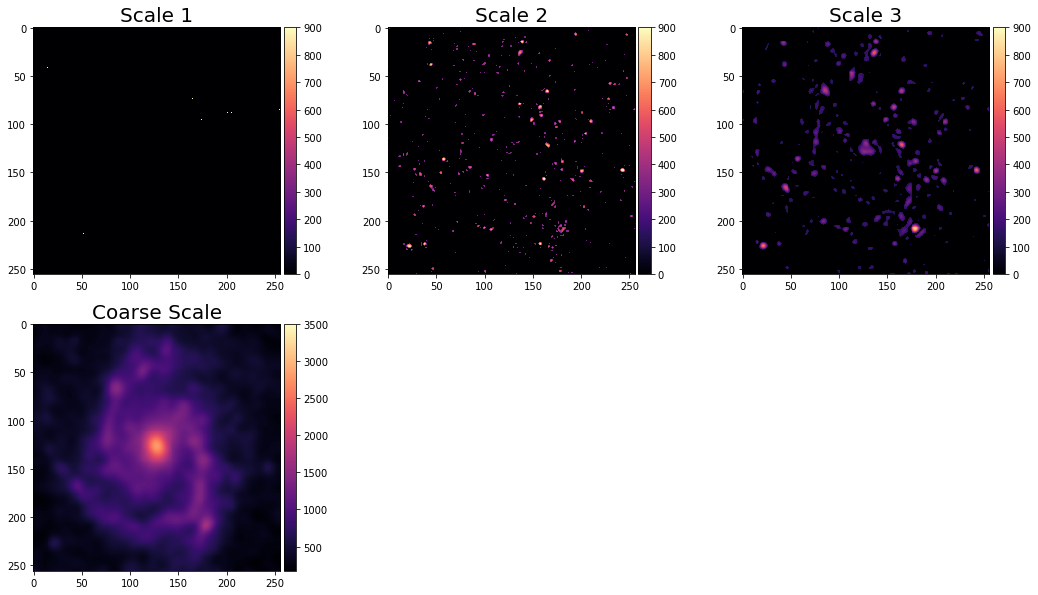

In [22]:
# Threshold the decomposed noisy image (not including the coarse scale)
ngc2997_thresh = np.vstack([thresh(ngc2997_noisy_decomp[:-1].T, weights).T, ngc2997_noisy_decomp[-1, None]])

# Plot the thresholded decomposition
plot_decomp(ngc2997_thresh)

We can see that the first scale, which was almost entirely composed of noise, is now virtually empty, while the high spatial frequency features in the remaining scales have been retained. 

### Final Recombination

The last step is to recombine the thresholed decomposition in order to reconstruct our denoised image. 

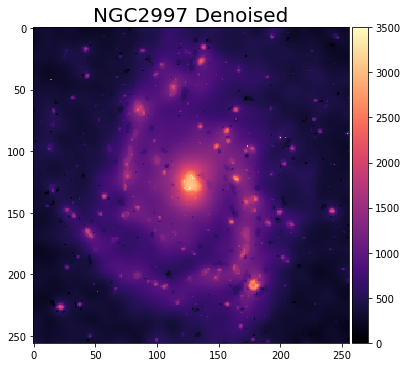

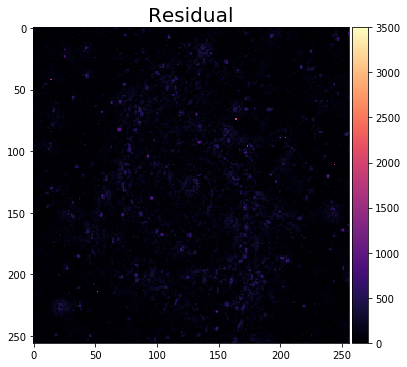

In [23]:
# Recombine the wavelet scales
ngc2997_denoised = recombine(ngc2997_thresh)

# Plot the denoised image and the corresponding residual
plot_image(ngc2997_denoised, title='NGC2997 Denoised')
plot_image(ngc2997 - ngc2997_denoised, title='Residual')

While our denoised image is not as sharp as the original clean image, it is pretty much noise free and has retained most of the high spatial frequency features.

Hopefully this has given you a good idea of how useful sparsity can be for handling astrophysical images.

## 7 Exercise
---

Use what you have learned in this notebook to write a one-step denoising function (*i.e.* a function that takes a noisy image as the input and returns a denoised image as the output).

1. Use your function to reproduce the denoising of NGC2997.
1. Now use your function to denoise the image in the file `saturn_noisy.fits`.
1. Display your denoised image of Saturn.

> Hint: It might be useful to use some of the helper functions provided.

In [24]:
# Answer
def denoise(data):
    
    sigma_est_scales = sigma_scales(noise_est(data))
    weights = np.array([4] + [3] * sigma_est_scales[:-1].size) * sigma_est_scales
    data_decomp = decompose(data)
    data_thresh = np.vstack([thresh(data_decomp[:-1].T, weights).T, data_decomp[-1, None]])
    
    return recombine(data_thresh)


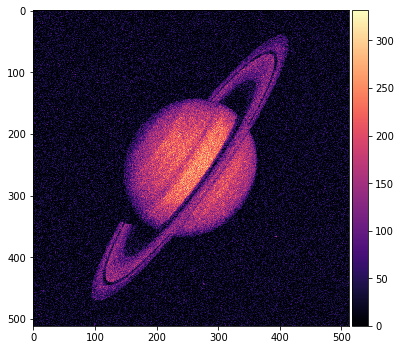

In [26]:
saturn_noisy = getdata('./data/saturn_noisy.fits')
plot_image(saturn_noisy, vmax=None)

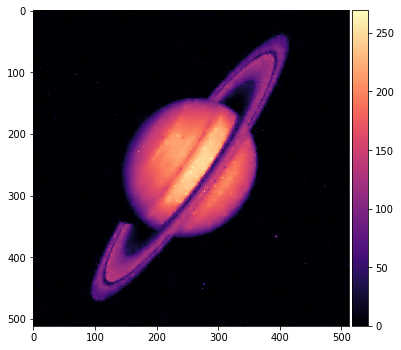

In [27]:
plot_image(denoise(saturn_noisy), vmax=None)